In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

2023-12-08 18:41:43.756435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 18:41:43.790039: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 18:41:43.790616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 18:41:44.521039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  0
True


2023-12-08 18:41:47.841414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:41:47.866594: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #RGB CHANNELS

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dermnet_23/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dermnet_23/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15557 files belonging to 23 classes.


2023-12-08 18:05:49.980901: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:05:49.981217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:05:49.981418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 4002 files belonging to 23 classes.


In [6]:
for image_batch,label_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
(32,)
[15  6 13 20 11 20 10 21 18 18 14 17 16 12 14 12 17 22 18 14 18 20 20 18
  6  3  6 16 11 18 22 14]


In [7]:
for image_batch,label_batch in test_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
(32,)
[18  5  3 16 13 14 12 14  0 16 18 16 18  0  5  9 12  2 12 22 14 18 14 12
 12  8 17  1 15  0 16 15]


In [8]:
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

val_dataset = test_dataset.take(test_size // 2)
test_dataset = test_dataset.skip(test_size // 2)

In [9]:
for image_batch,label_batch in val_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
(32,)
[18 13 12 18  1 16  0 13  2 16 22 18 18 12 18 13 13 16 12 10 12  9  6 16
  4 16 18 12  5 18 10 14]


In [10]:
len(train_dataset),len(val_dataset),len(test_dataset) 

(487, 63, 63)

In [11]:
train_dataset=train_dataset.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)  

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [13]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [14]:
CHANNELS=3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 26

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
#CHANNELS=3
# Define the CNN model
#model = models.Sequential([
    #resize_and_rescale,
   # data_augmentation,
    #layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    #layers.MaxPooling2D(2, 2),
    #layers.Conv2D(64, (3, 3), activation='relu'),
   # layers.MaxPooling2D(2, 2),
    #layers.Conv2D(128, (3, 3), activation='relu'),
    #layers.MaxPooling2D(2, 2),
    #layers.MaxPooling2D(2, 2),
    #layers.Flatten(),
    #layers.Dense(512, activation='relu'),
    #ayers.Dense(7, activation='softmax')
#])
#model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [17]:
#compile using optimers
model.compile(
    optimizer='adam',#optimers are used to reduce the loss by changing the weights and learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy #common loss function for multiclass classification where the labels are integers
    #loss function measures how well the model is performing and the optimer aims to minize the value
    (from_logits=False),#  if the model is not giving the probability then we set it to false
    metrics=['accuracy']
)

In [18]:
if tf.config.list_physical_devices('GPU'):
    device_name = '/GPU:0'
else:
    device_name = '/CPU:0'
print('Using device:', device_name)

Using device: /GPU:0


In [19]:
with tf.device(device_name):
    history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1 #it will show the progress bar
)

Epoch 1/20


2023-12-08 16:05:22.668117: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-08 16:05:23.619519: I external/local_xla/xla/service/service.cc:168] XLA service 0x563e04868450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 16:05:23.619597: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-08 16:05:23.638691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702031723.861200   13116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


487/487 [==============================] - 196s 394ms/step - loss: 3.0965 - accuracy: 0.1081 - val_loss: 2.9159 - val_accuracy: 0.1111
Epoch 2/20
487/487 [==============================] - 29s 59ms/step - loss: 2.8892 - accuracy: 0.1418 - val_loss: 2.8805 - val_accuracy: 0.1488
Epoch 3/20
487/487 [==============================] - 29s 59ms/step - loss: 2.8307 - accuracy: 0.1650 - val_loss: 2.8365 - val_accuracy: 0.1701
Epoch 4/20
487/487 [==============================] - 29s 60ms/step - loss: 2.7673 - accuracy: 0.1852 - val_loss: 2.8141 - val_accuracy: 0.1806
Epoch 5/20
487/487 [==============================] - 29s 59ms/step - loss: 2.6962 - accuracy: 0.2073 - val_loss: 2.7228 - val_accuracy: 0.2044
Epoch 6/20
487/487 [==============================] - 29s 59ms/step - loss: 2.6412 - accuracy: 0.2193 - val_loss: 2.6839 - val_accuracy: 0.2118
Epoch 7/20
487/487 [==============================] - 28s 58ms/step - loss: 2.5931 - accuracy: 0.2318 - val_loss: 2.7007 - val_accuracy: 0.2044
E

In [21]:
scores=model.evaluate(test_dataset)

63/63 [==============================] - 20s 300ms/step - loss: 3.3778 - accuracy: 0.2427


In [22]:
scores

[3.3777964115142822, 0.24269889295101166]

In [ ]:
history

In [23]:
history.history['accuracy']

[0.1080542504787445,
 0.141801118850708,
 0.1650061011314392,
 0.18518994748592377,
 0.20730218291282654,
 0.21925821900367737,
 0.23179276287555695,
 0.24786269664764404,
 0.26226136088371277,
 0.27755993604660034,
 0.2958153784275055,
 0.3136851489543915,
 0.33194059133529663,
 0.3500032126903534,
 0.3696728050708771,
 0.3799575865268707,
 0.41029760241508484,
 0.42501768469810486,
 0.443015992641449,
 0.45246511697769165]

In [24]:
history.params


{'verbose': 1, 'epochs': 20, 'steps': 487}

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

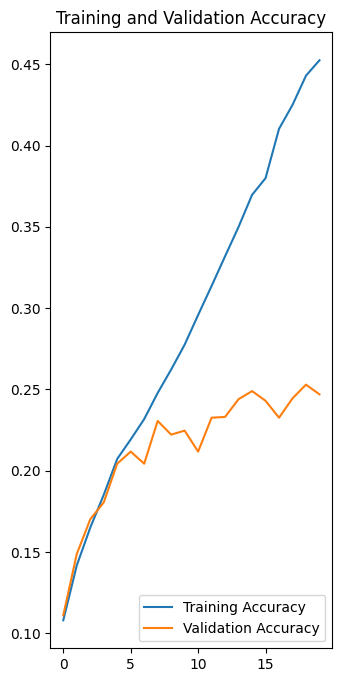

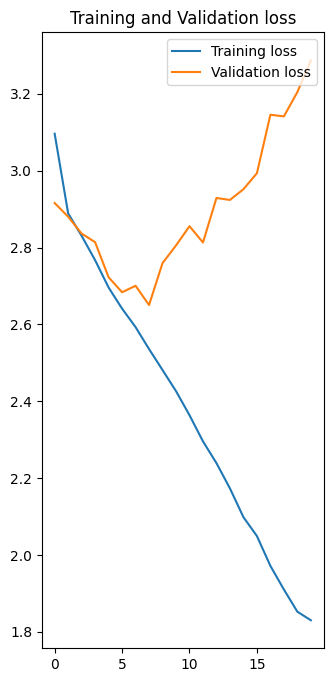

In [26]:
#chat for accuracy ,we need to see the diffrence


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),acc,label='Training Accuracy')
plt.plot(range(20),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


#plot of loss basically the loss should be decrease
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),loss,label='Training loss')
plt.plot(range(20),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')


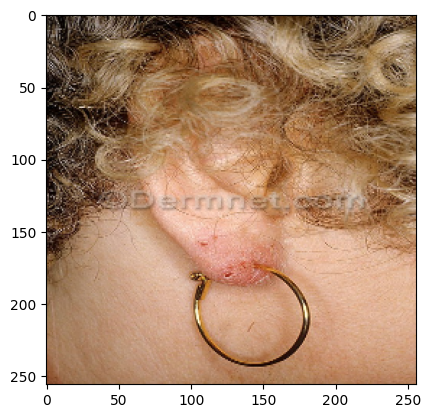

In [28]:
for image_batch, labels_batch in test_dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))


In [34]:
classes_names = train_dataset.class_names


first image to predict
actual label Vasculitis Photos
1/1 [==============================] - 0s 263ms/step
predicted label Acne and Rosacea Photos


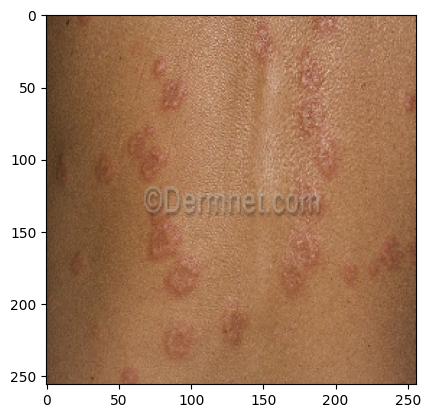

In [35]:

#we are here checking that the prediction model and the actual model are the same 


import numpy as np
for image_batch, labels_batch in test_dataset.take(1):
    first_image=image_batch[6].numpy().astype('uint8')
    first_label=labels_batch[6].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",classes_names[first_label])
    
    #we are doing batch prediction in that i need to know only the first image
    batch_prediction=model.predict(image_batch)
    print("predicted label",classes_names[np.argmax(batch_prediction[6])])
   
    

In [ ]:


#taking mode and the prediction as the input  and giving what is their class and the confidence

def predict(model,img):
    image_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(image_array,0)#cerate a batch
    prediction=model.predict(img_array)
    prediction_class=classes_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return prediction_class,confidence#it tells u abt the accuracy of the model
    
    


1/1 [==============================] - 0s 89ms/step


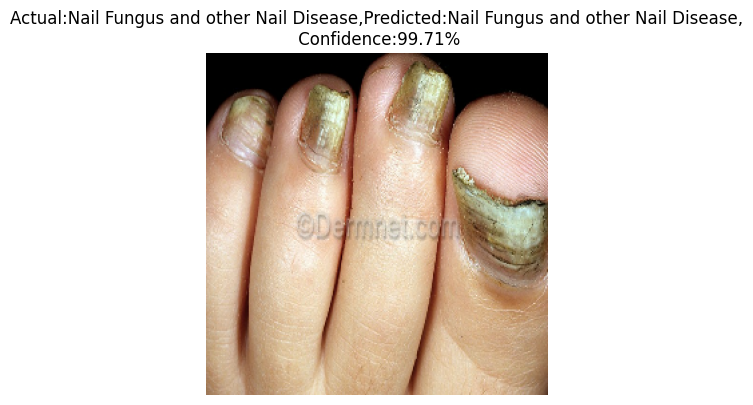

In [ ]:

#we are not checking with the whole batch we are just checking with 9 images by calling the predicted function and telling how it being predicted

plt.figure(figsize=(15,20))
for images,labels in test_ds.take():
    for i in range(1):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=classes_names[labels[i]]
        #inorder to print the title we use this
        plt.title(f"Actual:{actual_class},Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis('off')
    

In [ ]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [ ]:
import os
os.listdir('../models')

['1']